In [1]:
import numpy as np
from numpy import ma
import pandas as pd
import math
from sklearn import metrics, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
import sklearn
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
print(os.getcwd())
relative_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
data = pd.read_csv(relative_path+'/preprocessed_data/non_split_dataset_OHE/total_subset.csv')
data = data.drop(['evil','userId'],axis=1)
print(data.shape)

a:\Desktop\FYP Final Files\notebooks\Unsupervised_ML
(1141078, 13)


In [3]:
data.head(1)

,processId,parentProcessId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc,sus
0,1,0,1,157,5,0,1,0,0,0,0,0,1


In [4]:
X = data
y = data['sus']

In [5]:
X.head(1)

,processId,parentProcessId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc,sus
0,1,0,1,157,5,0,1,0,0,0,0,0,1


In [6]:
y.head(1)

0    1
Name: sus, dtype: int64

# Helpers

In [7]:
def print_metrics(y_true, y_predicted):

    accuracy = accuracy_score(y_true, y_predicted)   
    metrics_results = precision_recall_fscore_support(y_true, y_predicted, average="weighted", pos_label=1)
    average_precision = average_precision_score(y_true, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
    mcc = matthews_corrcoef(y_true, y_predicted)
    
    print(f'Accuracy:\t{accuracy:.3f}')
    print(f'Precision:\t{metrics_results[0]}')
    print(f'Recall:\t\t{metrics_results[1]:.3f}')
    print(f'F1-Score:\t{metrics_results[2]:.3f}')
    print("Average Precision Score:", average_precision)
    print("Balanced Accuracy Score:", balanced_accuracy)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_true , y_predicted)))
    
    #make confusion matrix
    confusion_matrixs = confusion_matrix(y_true, y_predicted)
    

    TP = confusion_matrixs[1][1]
    TN = confusion_matrixs[0][0]
    FP = confusion_matrixs[0][1]
    FN = confusion_matrixs[1][0]


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrixs, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    # Print roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, )
    display.plot()
    plt.show()


    # Assuming test_df_labels is your true labels and mse_test contains continuous score values
    precision, recall, _ = precision_recall_curve(y_true, y_predicted)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [8]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [9]:
def prepare_labels(y_predicted):
    """
    Helper function to help map out the outputs from models that return -1 for outliers and 1 for inliners.
    """
    y_predicted[y_predicted == 1] = 0
    y_predicted[y_predicted == -1] = 1
    return y_predicted

# Split data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)

In [11]:
X_train.shape

(912862, 13)

In [12]:
X_train = X_train[X_train['sus']==0]
X_train = X_train.drop(columns='sus')
X_test = X_test.drop(columns='sus')

In [13]:
X_train.shape

(774175, 12)

In [14]:
X_train.head()

,processId,parentProcessId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc
335256,1,1,0,1005,4,0,0,0,0,0,0,1
1043942,1,1,0,1005,4,0,0,0,0,0,0,1
1028670,1,1,1,5,2,0,1,0,0,0,0,0
674605,1,1,0,3,1,0,0,0,0,0,1,0
714299,1,1,0,1005,4,0,0,0,0,0,1,0


# Model training

## Isolation forest

In [15]:
iforest = IsolationForest(random_state=0,contamination=0.05)
iforest.fit(X_train)

IsolationForest(contamination=0.05, random_state=0)

In [16]:
ypred_iforest = iforest.predict(X_test)
ypred_iforest = prepare_labels(ypred_iforest)
print(classification_report(y_test, ypred_iforest,digits=3))

              precision    recall  f1-score   support

           0      0.841     0.950     0.892    193389
           1      0.002     0.000     0.001     34827

    accuracy                          0.805    228216
   macro avg      0.421     0.475     0.446    228216
weighted avg      0.713     0.805     0.756    228216



Accuracy:	0.805
Precision:	0.712624230569691
Recall:		0.805
F1-Score:	0.756
Average Precision Score: 0.15254036450928912
Balanced Accuracy Score: 0.4751467061310018
Matthews Correlation Coefficient (MCC): -0.08855747002139984
AUC : 0.47515


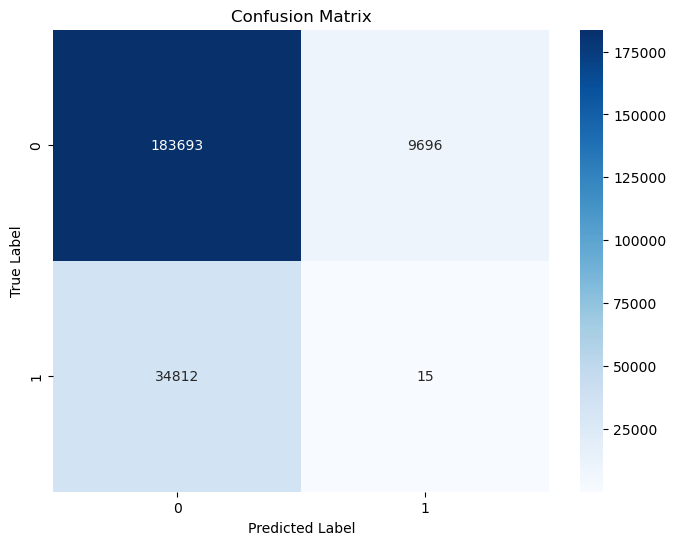

True Positives (TP): 15
True Negatives (TN): 183693
False Positives (FP): 9696
False Negatives (FN): 34812


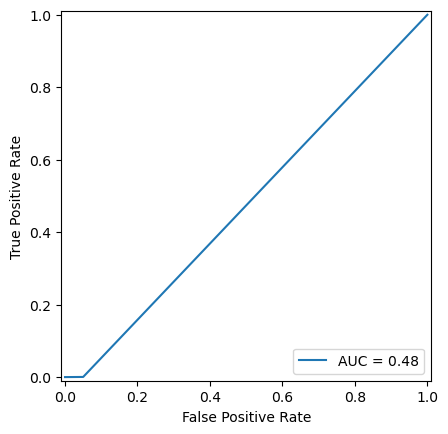

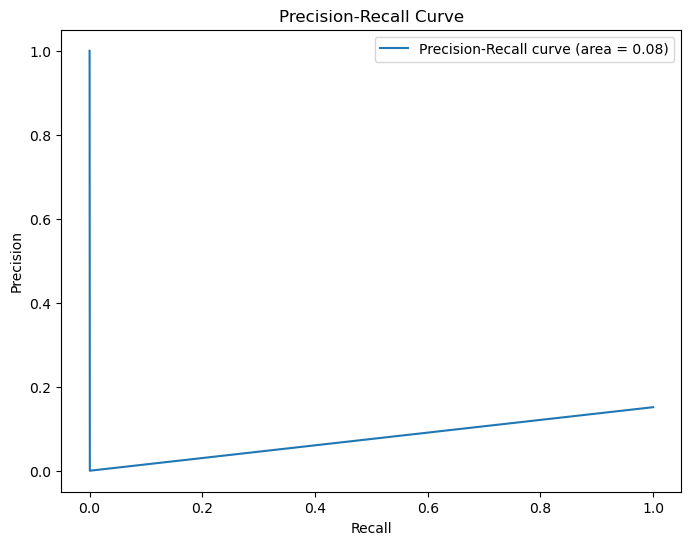

In [17]:
print_metrics(y_test,ypred_iforest)

## Local Outlier Factor

In [18]:
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.05, novelty=True)

In [19]:
predicted_scores = lof.decision_function(X_test)
predicted_labels = lof.predict(X_test)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    193389
           1       0.99      0.86      0.92     34827

    accuracy                           0.98    228216
   macro avg       0.99      0.93      0.96    228216
weighted avg       0.98      0.98      0.98    228216

Accuracy:	0.979
Precision:	0.9788666407613236
Recall:		0.979
F1-Score:	0.978
Average Precision Score: 0.8799120364714873
Balanced Accuracy Score: 0.9317372156657256
Matthews Correlation Coefficient (MCC): 0.9152517223666695
AUC : 0.93174


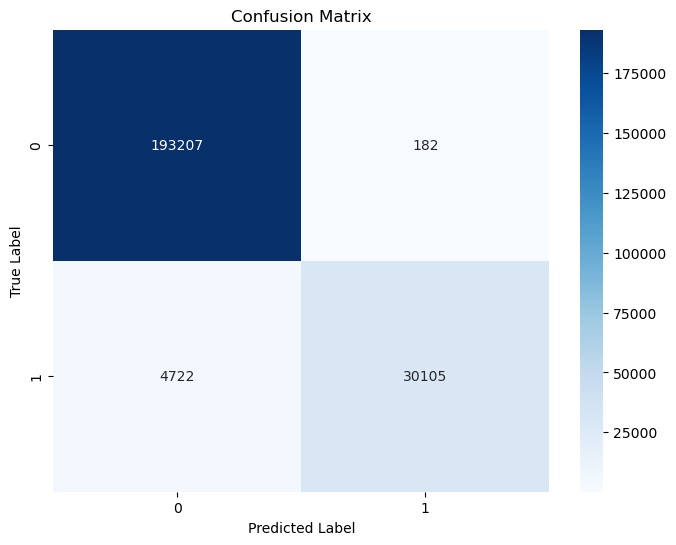

True Positives (TP): 30105
True Negatives (TN): 193207
False Positives (FP): 182
False Negatives (FN): 4722


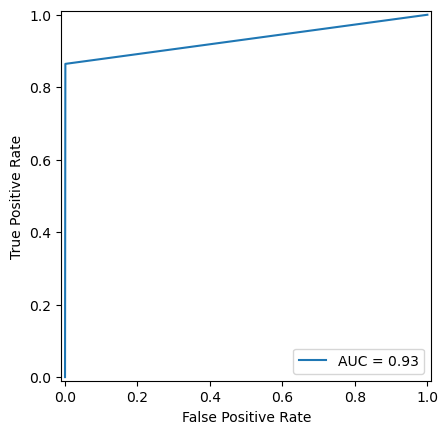

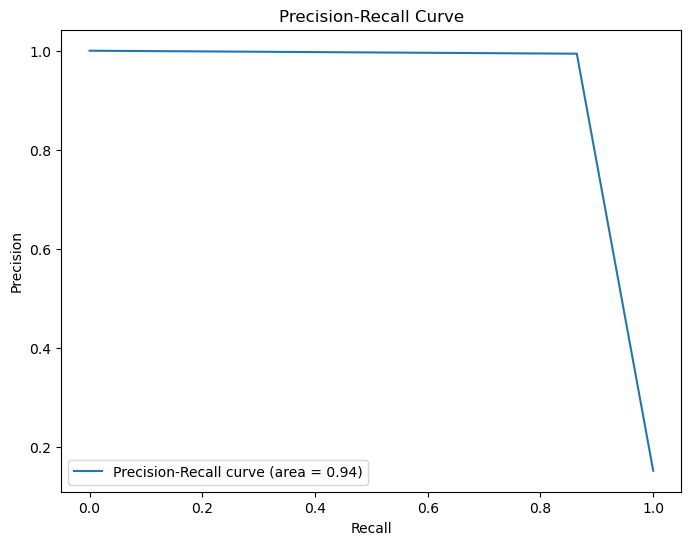

In [20]:
print(classification_report(y_test, predicted_labels))
print_metrics(y_test,predicted_labels)

## SVM

In [21]:
model = linear_model.SGDOneClassSVM(random_state=0).fit(X_train)

              precision    recall  f1-score   support

           0       0.80      0.71      0.75    193389
           1       0.02      0.04      0.03     34827

    accuracy                           0.61    228216
   macro avg       0.41      0.37      0.39    228216
weighted avg       0.68      0.61      0.64    228216

Accuracy:	0.609
Precision:	0.6849833555113135
Recall:		0.609
F1-Score:	0.644
Average Precision Score: 0.14767852060261066
Balanced Accuracy Score: 0.3747035121645893
Matthews Correlation Coefficient (MCC): -0.20799376300519612
AUC : 0.37470


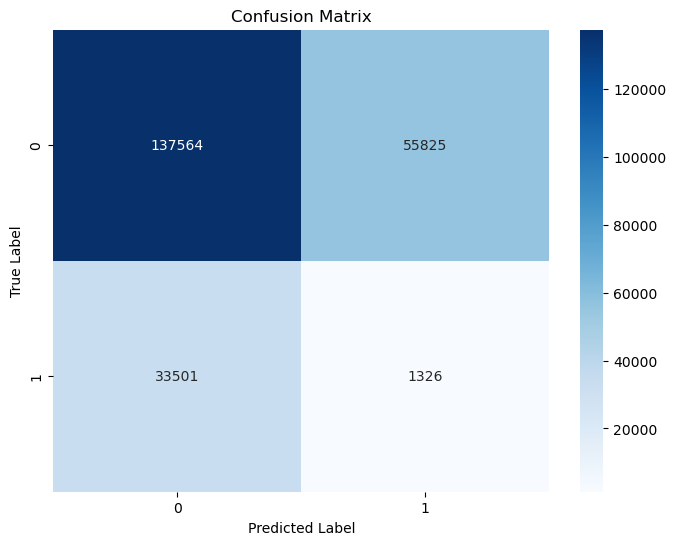

True Positives (TP): 1326
True Negatives (TN): 137564
False Positives (FP): 55825
False Negatives (FN): 33501


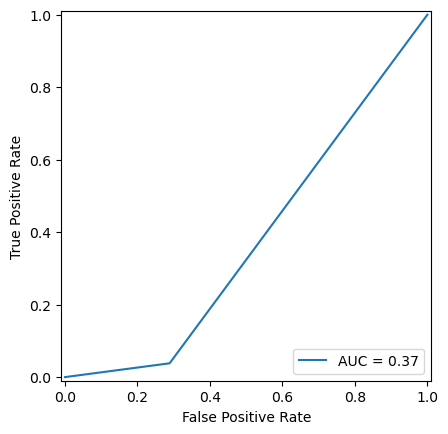

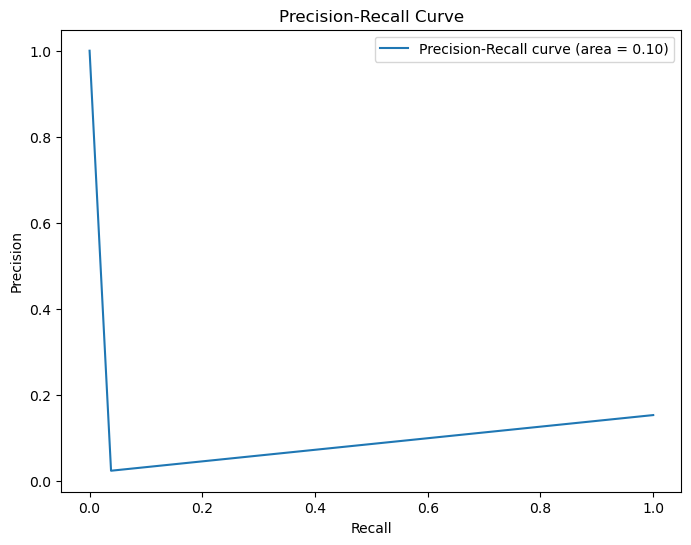

In [22]:
y_pred_svm = model.predict(X_test)
y_pred_svm = prepare_labels(y_pred_svm)
print(classification_report(y_test,y_pred_svm))
print_metrics(y_test,y_pred_svm)

## Autoenconder

In [23]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1] # Number of features

# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

# Bottleneck
bottleneck = Dense(32, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(bottleneck)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [24]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_weights.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[checkpoint]
)
autoencoder.load_weights("best_weights.keras")

Epoch 1/20
3008/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 468.9999
Epoch 1: val_loss improved from inf to 0.07808, saving model to best_weights.keras
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 466.6533 - val_loss: 0.0781
Epoch 2/20
2988/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0444
Epoch 2: val_loss did not improve from 0.07808
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0448 - val_loss: 0.1182
Epoch 3/20
3013/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3783
Epoch 3: val_loss improved from 0.07808 to 0.01520, saving model to best_weights.keras
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3780 - val_loss: 0.0152
Epoch 4/20
2994/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0763
Epoch 4: val_loss did not improve from 0.01520
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0770 - val_loss: 0.0230
Epoch 5/20
3015/3025 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1565
Epoch 5: val_loss did not improve from 0.01520
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 5

In [25]:
# Predict on the test set
X_test_pred = autoencoder.predict(X_test)

X_train_pred = autoencoder.predict(X_train)

7132/7132 ━━━━━━━━━━━━━━━━━━━━ 5s 680us/step
24193/24193 ━━━━━━━━━━━━━━━━━━━━ 17s 684us/step


In [26]:
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

In [27]:

threshold = np.quantile(mse_train, 0.99)

# Predict anomalies on the test set
y_pred_test = (mse_test > threshold)
y_pred_test = y_pred_test.astype(int)

In [28]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_test) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.85      0.99      0.91    193389
           1       0.26      0.02      0.04     34827

    accuracy                           0.84    228216
   macro avg       0.55      0.50      0.47    228216
weighted avg       0.76      0.84      0.78    228216

AUC-ROC: 0.50


Accuracy:	0.842
Precision:	0.7588045925604104
Recall:		0.842
F1-Score:	0.780
Average Precision Score: 0.15468719454247304
Balanced Accuracy Score: 0.5047240837822913
Matthews Correlation Coefficient (MCC): 0.032039104005182735
AUC : 0.50472


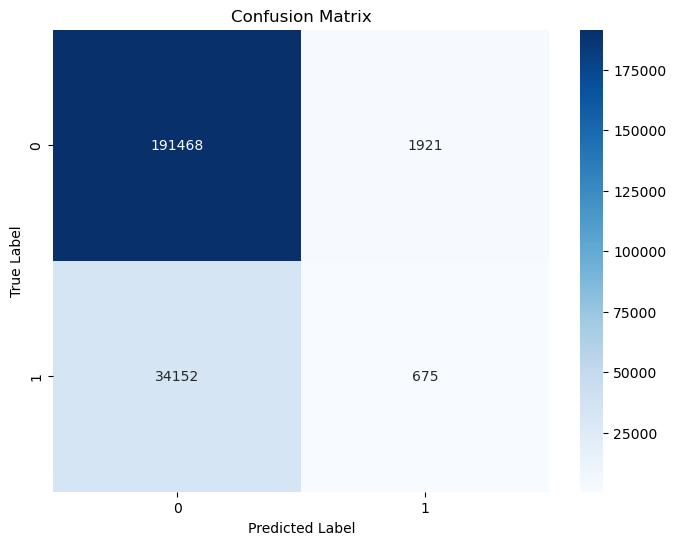

True Positives (TP): 675
True Negatives (TN): 191468
False Positives (FP): 1921
False Negatives (FN): 34152


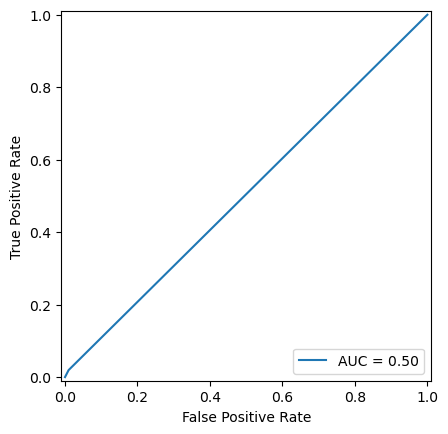

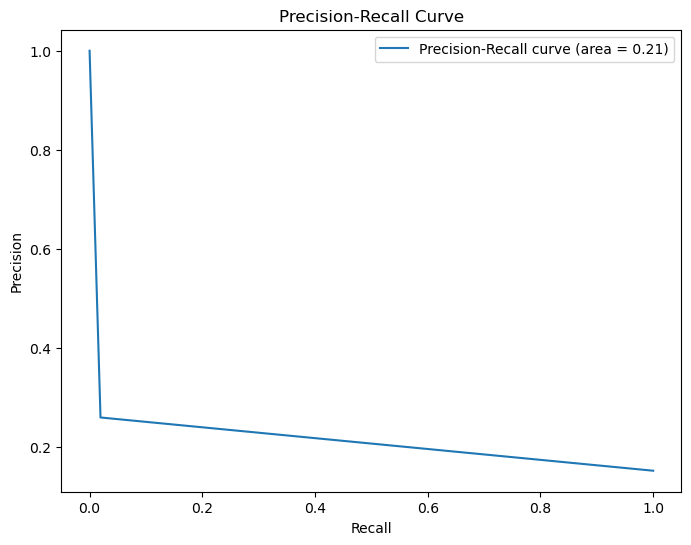

In [29]:
print_metrics(y_test,y_pred_test)